In [147]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
plot_params = {'color': '0.75',
                'style': '.-',
                'markeredgecolor': '0.25',
                'markerfacecolor': '0.25',
                'legend': False}
sns.set_style("dark")
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor as xgb
from sklearn import linear_model, svm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
def rmse(y, y_pred):
    return np.sqrt(((y - y_pred) ** 2).mean())
def mse(y, y_pred):
    return ((y - y_pred) ** 2).mean()
def mae(y, y_pred):
    return ((y - y_pred).abs()).mean()
def mape(y, y_pred):
    return ((y - y_pred).abs() / y).mean() * 100
def evaluate(y, y_pred):
    print("MAE:", mae(y, y_pred))
    #print("MSE:", mse(y, y_pred))
    print("RMSE:", rmse(y, y_pred))
    print("MAPE:", mape(y, y_pred))

In [7]:
air_line_path = 'AirPassengers.csv'

In [8]:
def forcast_plot(y, y_pred, y_fore):

    ax = y.plot(**plot_params, alpha=0.5, title="airline-passengers", ylabel="items sold")
    ax = y_pred.plot(ax=ax, linewidth=3, label="Train", color='C0')
    ax = y_fore.plot(ax=ax, linewidth=3, label="Forecast", color='C3')
    ax.legend();


def plot_reg_scatter(y, x):
    temp_frame = pd.concat([x, y], axis=1)
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot('Time', 'Passengers', data=temp_frame, color='0.75')
    ax = sns.regplot(x='Time', y='Passengers', data=temp_frame, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_title('Time Plot of Passengers');

def get_time(frame):
    return pd.DataFrame(np.arange(len(frame.index)), columns=['Time'], index=frame.index)


def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df_copy = df.copy()

    df_copy['date'] = df_copy.index
    df_copy['dayofweek'] = df_copy['date'].dt.dayofweek
    df_copy['quarter'] = df_copy['date'].dt.quarter
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['year'] = df_copy['date'].dt.year
    df_copy['dayofyear'] = df_copy['date'].dt.dayofyear
    df_copy['weekofyear'] = df_copy['date'].dt.weekofyear
    
    X = df_copy[['dayofweek','quarter','month','year',
           'dayofyear', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X


def add_lags(df, lags):

    df_copy = df.copy()
    df_copy.drop('Passengers', axis=1, inplace=True)

    for i in lags:
        df_copy[f'lag{i}'] = df['Passengers'].shift(i)


    return df_copy

In [9]:
air_line = pd.read_csv(air_line_path,
                       parse_dates=['Month'],
                        infer_datetime_format=True)

air_line = air_line.set_index(['Month']).sort_index()



air_line

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [10]:
air_line.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


## Investigating the data

To detect the trend in the AirPassengers dataset, a regression plot (regplot) was plotted using the Seaborn library in Python. The regplot shows a clear upward trend in the data, indicating that the number of airline passengers increased steadily over time. This is consistent with historical trends in air travel and supports the research question of the project, which aims to investigate the long-term trend in airline passenger numbers. The regplot is included below for reference.

In [16]:
air_line.rename(columns = {'#Passengers':'Passengers'}, inplace=True)

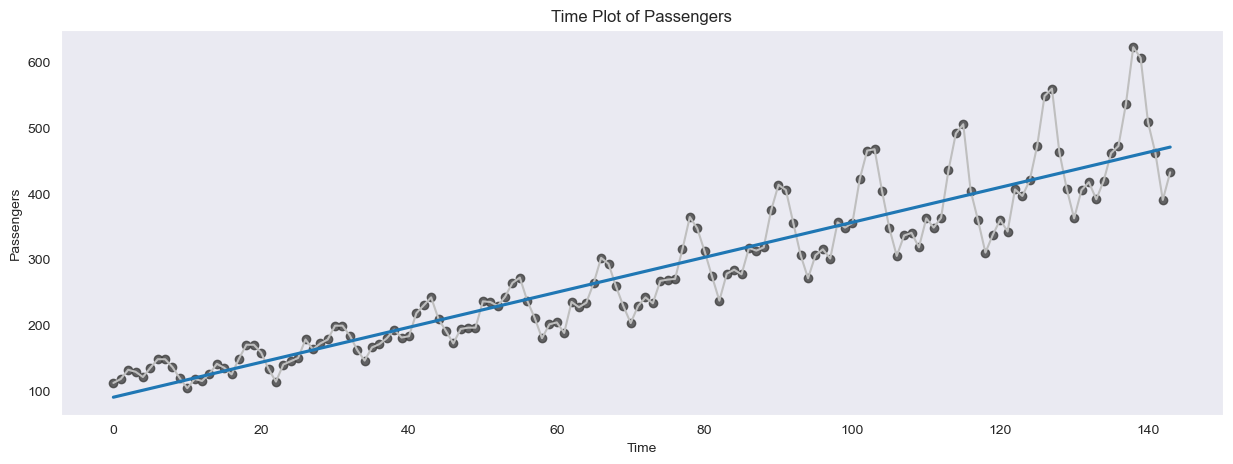

In [21]:
time = get_time(air_line[['Passengers']])

plot_reg_scatter(air_line[['Passengers']], time)

We can see that there's an increasing Trend over the data

## Detrending the data to make it stationary

To improve the accuracy of the time series analysis, a detrended dataset was created by removing the trend component from the AirPassengers data. This was accomplished using a Linear regresion. The detrended dataset was then used to test the performance of an XGBoost model in predicting future airline passenger numbers.

In addition, a trend feature was extracted from the AirPassengers data to include in the XGBoost model. This trend feature represents the long-term upward trend in airline passenger numbers over the time period of the dataset. Including this feature in the model improves its ability to capture the overall trend in the data, which is an important factor in predicting future values.

The results of the XGBoost model with and without the trend feature will be presented in the results section of this documentation, along with any visualizations or graphs used to illustrate the findings.

In [22]:
air_line['Time'] = np.arange(len(air_line.index), dtype='float')

In [25]:
trend_model = LinearRegression()
trend_model.fit(air_line[['Time']], air_line['Passengers'])

trend = pd.DataFrame(trend_model.predict(air_line[['Time']]), columns=['Passengers'], index=air_line.index)

After analyzing the AirPassengers dataset, we determined that the trend component of the data is multiplicative in nature. Therefore, to normalize the data and make it more suitable for time series analysis, we divided the original data by the trend component.

In [26]:
detrended_y = pd.DataFrame(air_line['Passengers'].values / trend['Passengers'].values,
                           columns=['Passengers'], index=air_line.index)

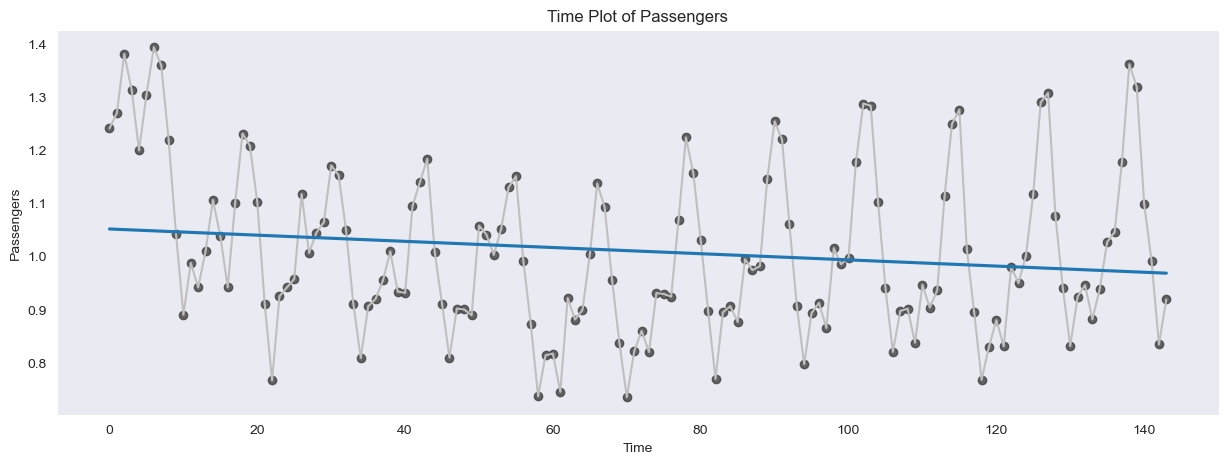

In [27]:
time = get_time(detrended_y)
plot_reg_scatter(detrended_y, time)

## Train/Test Split

To evaluate the performance of our time series models, we used a testing period of 2 years, which represents two cycles of the seasonal pattern in the AirPassengers dataset. Since our data is of monthly frequency, this testing period covers 24 months or 2 complete years.

By using a testing period that spans multiple cycles, we can gain a more accurate evaluation of how well our models can capture seasonal patterns and make predictions over longer time periods. The testing period was selected by examining the seasonal pattern in the data and identifying the length of time required to capture at least two complete cycles.

This ensures that the testing period is representative of the overall pattern in the data, and allows us to evaluate the performance of our models in predicting seasonal patterns over a meaningful time frame.

The results of our time series models on the testing period will be presented in the results section of this documentation, along with any visualizations or graphs used to illustrate the findings. By using a testing period that spans multiple cycles, we can gain a more accurate understanding of the predictive power of our models and their ability to capture seasonal patterns in the AirPassengers dataset.

To evaluate the performance of our time series models, we split the AirPassengers dataset into training and testing sets. We created separate training and testing sets for the original data, the detrended data, and the trend feature data, as each of these datasets requires different modeling approaches.

In [28]:
split_date = '1959-01-01'

detrend_train = detrended_y.loc[detrended_y.index < split_date].copy()
detrend_test = detrended_y.loc[detrended_y.index >= split_date].copy()

train = air_line.loc[air_line.index < split_date].copy()
test = air_line.loc[air_line.index >= split_date].copy()

trend_train = trend[trend.index < split_date]
trend_test = trend[trend.index >= split_date]

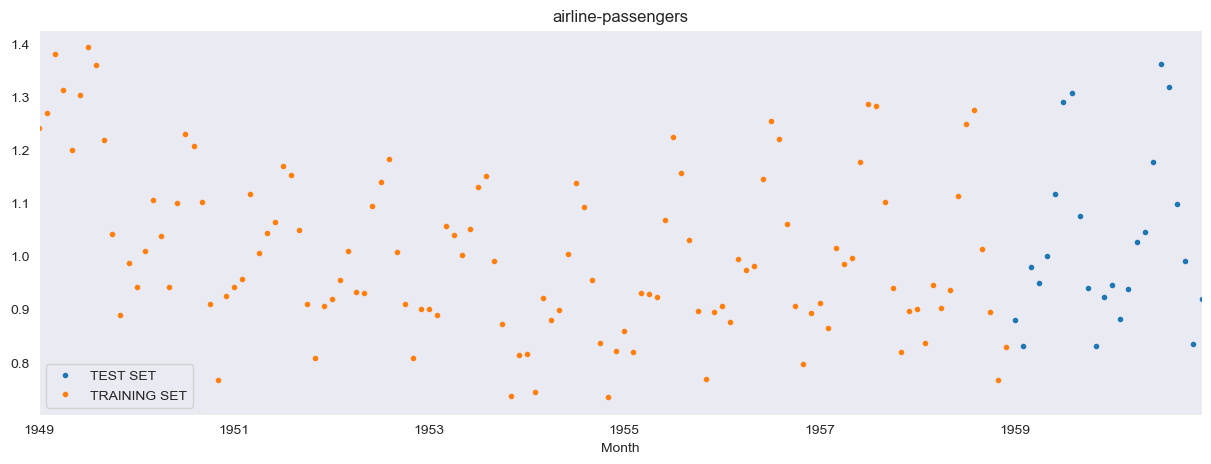

In [29]:
_ = detrend_test \
    .rename(columns={'Passengers': 'TEST SET'}) \
    .join(detrend_train.rename(columns={'Passengers': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='airline-passengers', style='.')


## Modeling

How XGBRegressor Forecasts Time Series
XGBRegressor uses a number of gradient boosted trees (referred to as n_estimators in the model) to predict the value of a dependent variable. This is done through combining decision trees (which individually are weak learners) to form a combined strong learner.
When forecasting a time series, the model uses what is known as a lookback period to forecast for a number of steps forward. For instance, if a lookback period of 1 is used, then the X_train (or independent variable) uses lagged values of the time series regressed against the time series at time t (Y_train) in order to forecast future values.
decision tree will predict the trend indicated by the last step of the training data into the future forever. Decision trees cannot extrapolate trends
So we need to get the trend using linear regresion model or moving average as we've done

To evaluate the impact of detrending on the performance of our time series models, we passed the original AirPassengers dataset to the XGBoost algorithm both before and after detrending. This allows us to compare the performance of XGBoost on the original data versus the detrended data and identify any improvements in accuracy that may result from removing the trend component.

In [32]:
reg = xgb(n_estimators=1000, early_stopping_rounds=10)

temp_train_x, temp_train_y = train['Time'], train.drop('Time', axis=1)
temp_test_x, temp_test_y = test['Time'], test.drop('Time', axis=1)

reg.fit(temp_train_x, temp_train_y,
        eval_set=[(temp_train_x, temp_train_y),
        (temp_test_x, temp_test_y)])

[0]	validation_0-rmse:188.51436	validation_1-rmse:358.49503
[1]	validation_0-rmse:136.29833	validation_1-rmse:283.10016
[2]	validation_0-rmse:100.07701	validation_1-rmse:233.37954
[3]	validation_0-rmse:75.17788	validation_1-rmse:196.59636
[4]	validation_0-rmse:57.97040	validation_1-rmse:186.81388
[5]	validation_0-rmse:45.13572	validation_1-rmse:177.21082
[6]	validation_0-rmse:35.68472	validation_1-rmse:167.90752
[7]	validation_0-rmse:28.87470	validation_1-rmse:163.20378
[8]	validation_0-rmse:23.59742	validation_1-rmse:158.05759
[9]	validation_0-rmse:19.34196	validation_1-rmse:154.17817
[10]	validation_0-rmse:16.18491	validation_1-rmse:151.24955
[11]	validation_0-rmse:13.74805	validation_1-rmse:149.13103
[12]	validation_0-rmse:11.74448	validation_1-rmse:147.33816
[13]	validation_0-rmse:10.21986	validation_1-rmse:145.82010
[14]	validation_0-rmse:9.09501	validation_1-rmse:144.53416
[15]	validation_0-rmse:8.27490	validation_1-rmse:143.44436
[16]	validation_0-rmse:7.62680	validation_1-rmse:

[139]	validation_0-rmse:0.09490	validation_1-rmse:137.35995
[140]	validation_0-rmse:0.09312	validation_1-rmse:137.35531
[141]	validation_0-rmse:0.09199	validation_1-rmse:137.35537
[142]	validation_0-rmse:0.08818	validation_1-rmse:137.35570
[143]	validation_0-rmse:0.08423	validation_1-rmse:137.35577
[144]	validation_0-rmse:0.08147	validation_1-rmse:137.35552
[145]	validation_0-rmse:0.08048	validation_1-rmse:137.35155
[146]	validation_0-rmse:0.07969	validation_1-rmse:137.35152
[147]	validation_0-rmse:0.07607	validation_1-rmse:137.35122
[148]	validation_0-rmse:0.07357	validation_1-rmse:137.35191
[149]	validation_0-rmse:0.07281	validation_1-rmse:137.34847
[150]	validation_0-rmse:0.07103	validation_1-rmse:137.34837
[151]	validation_0-rmse:0.06936	validation_1-rmse:137.34837
[152]	validation_0-rmse:0.06884	validation_1-rmse:137.34845
[153]	validation_0-rmse:0.06578	validation_1-rmse:137.34855
[154]	validation_0-rmse:0.06432	validation_1-rmse:137.34863
[155]	validation_0-rmse:0.06306	validati

[276]	validation_0-rmse:0.00358	validation_1-rmse:137.32983
[277]	validation_0-rmse:0.00344	validation_1-rmse:137.32983
[278]	validation_0-rmse:0.00337	validation_1-rmse:137.32983
[279]	validation_0-rmse:0.00324	validation_1-rmse:137.32983
[280]	validation_0-rmse:0.00314	validation_1-rmse:137.32983
[281]	validation_0-rmse:0.00307	validation_1-rmse:137.32983
[282]	validation_0-rmse:0.00304	validation_1-rmse:137.32983
[283]	validation_0-rmse:0.00300	validation_1-rmse:137.32983
[284]	validation_0-rmse:0.00295	validation_1-rmse:137.32983


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

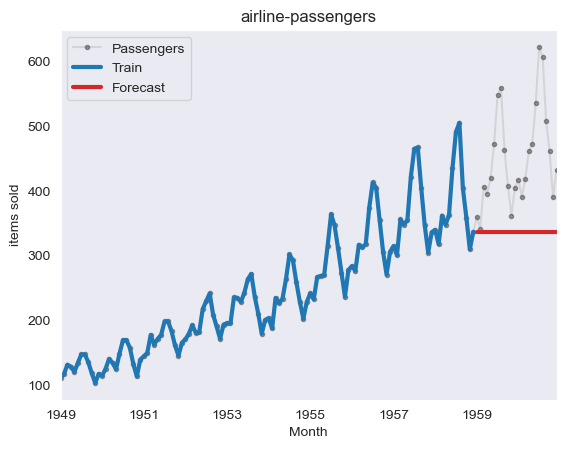

In [33]:
y_pred = pd.Series(reg.predict(temp_train_x), index=temp_train_x.index)
y_fore = pd.Series(reg.predict(temp_test_x), index=temp_test_x.index)

forcast_plot(air_line.drop('Time', axis=1), y_pred, y_fore)

After passing the original AirPassengers dataset to XGBoost, we found that the model's performance was not satisfactory. The model struggled to capture the underlying patterns and variations in the data, and as a result, the accuracy of its predictions was low.

To evaluate whether detrending could improve the performance of XGBoost on this dataset, we then passed the detrended AirPassengers dataset to XGBoost. We found that the model's performance improved significantly when using the detrended data, with a noticeable increase in accuracy compared to the original data.

This suggests that detrending the data can help to remove the trend component and enable XGBoost to better capture the underlying patterns and variations in the data. By removing the trend component, the model is better able to focus on the seasonal patterns and other fluctuations in the data, leading to more accurate predictions.

In [34]:
reg = xgb(n_estimators=1000, early_stopping_rounds=10)
reg.fit(get_time(detrend_train), detrend_train,
        eval_set=[(get_time(detrend_train), detrend_train), (get_time(detrend_test), detrend_test)])

[0]	validation_0-rmse:0.38493	validation_1-rmse:0.38983
[1]	validation_0-rmse:0.28696	validation_1-rmse:0.28569
[2]	validation_0-rmse:0.21990	validation_1-rmse:0.21419
[3]	validation_0-rmse:0.17445	validation_1-rmse:0.18478
[4]	validation_0-rmse:0.13966	validation_1-rmse:0.17133
[5]	validation_0-rmse:0.11682	validation_1-rmse:0.16921
[6]	validation_0-rmse:0.10254	validation_1-rmse:0.17464
[7]	validation_0-rmse:0.09000	validation_1-rmse:0.18030
[8]	validation_0-rmse:0.08104	validation_1-rmse:0.18034
[9]	validation_0-rmse:0.07399	validation_1-rmse:0.18312
[10]	validation_0-rmse:0.06943	validation_1-rmse:0.18262
[11]	validation_0-rmse:0.06216	validation_1-rmse:0.18291
[12]	validation_0-rmse:0.05866	validation_1-rmse:0.18400
[13]	validation_0-rmse:0.05539	validation_1-rmse:0.18342
[14]	validation_0-rmse:0.05013	validation_1-rmse:0.18464
[15]	validation_0-rmse:0.04749	validation_1-rmse:0.18511


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

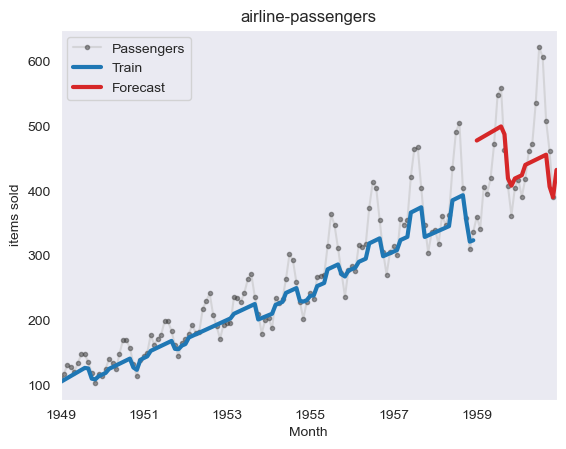

In [35]:
y_pred = pd.Series(reg.predict(get_time(detrend_train)), index=detrend_train.index)
y_fore = pd.Series(reg.predict(get_time(detrend_test)), index=detrend_test.index)

forcast_plot(air_line[['Passengers']], y_pred * trend_train['Passengers'], y_fore * trend_test['Passengers'])

So we will try to merge between them by adding the trend as a feature to the XGB

In [36]:
trend_train['Time'] = get_time(trend_train)
trend_test['Time'] = get_time(trend_test)

In [37]:
reg = xgb(n_estimators=1000)

reg.fit(trend_train, train.drop('Time', axis=1),
        eval_set=[(trend_train, train.drop('Time', axis=1)), (trend_test, test.drop('Time', axis=1))],
        early_stopping_rounds=50)


[0]	validation_0-rmse:188.51436	validation_1-rmse:358.49503
[1]	validation_0-rmse:136.29833	validation_1-rmse:283.10016
[2]	validation_0-rmse:100.07701	validation_1-rmse:233.37954
[3]	validation_0-rmse:75.17788	validation_1-rmse:196.59636
[4]	validation_0-rmse:57.97040	validation_1-rmse:186.81388
[5]	validation_0-rmse:45.13572	validation_1-rmse:177.21082
[6]	validation_0-rmse:35.68472	validation_1-rmse:167.90752
[7]	validation_0-rmse:28.87470	validation_1-rmse:163.20378
[8]	validation_0-rmse:23.59742	validation_1-rmse:158.05759
[9]	validation_0-rmse:19.34196	validation_1-rmse:154.17817
[10]	validation_0-rmse:16.18491	validation_1-rmse:151.24955
[11]	validation_0-rmse:13.74805	validation_1-rmse:149.13103
[12]	validation_0-rmse:11.74448	validation_1-rmse:147.33816
[13]	validation_0-rmse:10.21986	validation_1-rmse:145.82010
[14]	validation_0-rmse:9.09501	validation_1-rmse:144.53416
[15]	validation_0-rmse:8.27490	validation_1-rmse:143.44436
[16]	validation_0-rmse:7.62680	validation_1-rmse:

[139]	validation_0-rmse:0.09490	validation_1-rmse:137.35995
[140]	validation_0-rmse:0.09312	validation_1-rmse:137.35531
[141]	validation_0-rmse:0.09199	validation_1-rmse:137.35537
[142]	validation_0-rmse:0.08818	validation_1-rmse:137.35570
[143]	validation_0-rmse:0.08423	validation_1-rmse:137.35577
[144]	validation_0-rmse:0.08147	validation_1-rmse:137.35552
[145]	validation_0-rmse:0.08048	validation_1-rmse:137.35155
[146]	validation_0-rmse:0.07969	validation_1-rmse:137.35152
[147]	validation_0-rmse:0.07607	validation_1-rmse:137.35122
[148]	validation_0-rmse:0.07357	validation_1-rmse:137.35191
[149]	validation_0-rmse:0.07281	validation_1-rmse:137.34847
[150]	validation_0-rmse:0.07103	validation_1-rmse:137.34837
[151]	validation_0-rmse:0.06936	validation_1-rmse:137.34837
[152]	validation_0-rmse:0.06884	validation_1-rmse:137.34845
[153]	validation_0-rmse:0.06578	validation_1-rmse:137.34855
[154]	validation_0-rmse:0.06432	validation_1-rmse:137.34863
[155]	validation_0-rmse:0.06306	validati

[276]	validation_0-rmse:0.00358	validation_1-rmse:137.32983
[277]	validation_0-rmse:0.00344	validation_1-rmse:137.32983
[278]	validation_0-rmse:0.00337	validation_1-rmse:137.32983
[279]	validation_0-rmse:0.00324	validation_1-rmse:137.32983
[280]	validation_0-rmse:0.00314	validation_1-rmse:137.32983
[281]	validation_0-rmse:0.00307	validation_1-rmse:137.32983
[282]	validation_0-rmse:0.00304	validation_1-rmse:137.32983
[283]	validation_0-rmse:0.00300	validation_1-rmse:137.32983
[284]	validation_0-rmse:0.00295	validation_1-rmse:137.32983
[285]	validation_0-rmse:0.00283	validation_1-rmse:137.32983
[286]	validation_0-rmse:0.00282	validation_1-rmse:137.32983
[287]	validation_0-rmse:0.00272	validation_1-rmse:137.32983
[288]	validation_0-rmse:0.00263	validation_1-rmse:137.32983
[289]	validation_0-rmse:0.00259	validation_1-rmse:137.32983
[290]	validation_0-rmse:0.00250	validation_1-rmse:137.32983
[291]	validation_0-rmse:0.00243	validation_1-rmse:137.32983
[292]	validation_0-rmse:0.00235	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

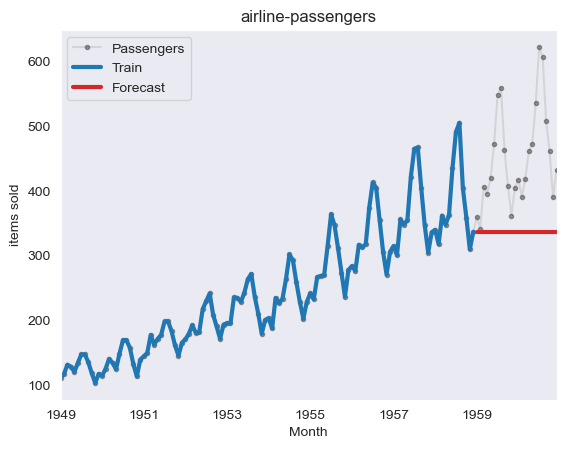

In [38]:
y_pred = pd.Series(reg.predict(trend_train), index=trend_train.index)
y_fore = pd.Series(reg.predict(trend_test), index=trend_test.index)

forcast_plot(air_line[['Passengers']], y_pred, y_fore)

After passing both the original and detrended AirPassengers datasets to XGBoost, we also experimented with adding the trend feature as an input to the model. This allowed the model to take into account the trend component of the data and potentially improve its ability to predict the future values of the time series.

However, we found that even with the trend feature given to the model, it did not significantly improve the accuracy of the model when making predictions on trended target. This suggests that the trend component of the data is not a significant factor in predicting future values of the time series.

To further improve the accuracy of our XGBoost model, we added several additional time-related features to the input data. These features included 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', and 'weekofyear', which provide additional information about the timing and seasonal patterns in the data.

In [39]:
temp_train_x, temp_train_y = create_features(train, 'Passengers')
temp_test_x, temp_test_y = create_features(test, 'Passengers')

reg = xgb(n_estimators=30, early_stopping_rounds=50)

reg.fit(temp_train_x, temp_train_y,
        eval_set=[(temp_train_x, temp_train_y),
        (temp_test_x, temp_test_y)])

[0]	validation_0-rmse:188.73189	validation_1-rmse:359.69349
[1]	validation_0-rmse:136.63521	validation_1-rmse:286.21986
[2]	validation_0-rmse:100.11903	validation_1-rmse:237.36598
[3]	validation_0-rmse:73.87813	validation_1-rmse:199.37048
[4]	validation_0-rmse:54.77169	validation_1-rmse:168.75982
[5]	validation_0-rmse:41.09459	validation_1-rmse:146.59000
[6]	validation_0-rmse:31.09370	validation_1-rmse:130.24992
[7]	validation_0-rmse:23.75021	validation_1-rmse:118.20603
[8]	validation_0-rmse:18.36638	validation_1-rmse:109.36105
[9]	validation_0-rmse:14.38410	validation_1-rmse:102.77834
[10]	validation_0-rmse:11.37287	validation_1-rmse:97.93815
[11]	validation_0-rmse:9.12671	validation_1-rmse:93.45870
[12]	validation_0-rmse:7.47677	validation_1-rmse:90.63056
[13]	validation_0-rmse:6.16351	validation_1-rmse:88.39228
[14]	validation_0-rmse:5.20215	validation_1-rmse:86.35211
[15]	validation_0-rmse:4.35169	validation_1-rmse:84.66789
[16]	validation_0-rmse:3.77376	validation_1-rmse:83.42316


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=30, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

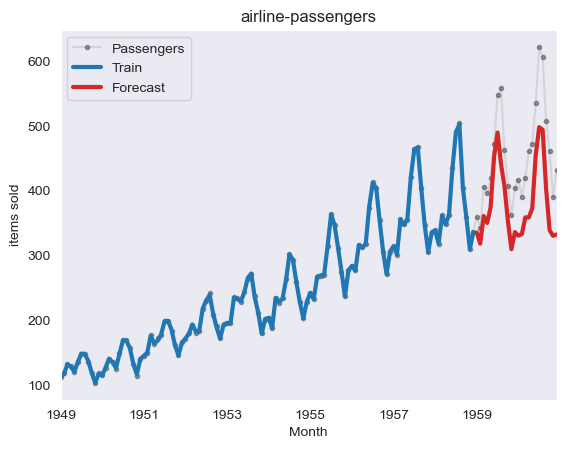

In [40]:
y_pred = pd.Series(reg.predict(temp_train_x), index=temp_train_x.index)
y_fore = pd.Series(reg.predict(temp_test_x), index=temp_test_x.index)

forcast_plot(air_line.drop('Time', axis=1), y_pred, y_fore)

To further improve the accuracy of our XGBoost model, we added several additional time-related features ('dayofweek', 'quarter', 'month', 'year', 'dayofyear', and 'weekofyear') to the detrended AirPassengers dataset. By incorporating these features into the XGBoost model, we were able to capture more of the underlying patterns and fluctuations in the data, leading to improved accuracy in predicting future values of the time series. And we can say this was our best accuarcy compared to other processing

In [41]:
temp_train_x, temp_train_y = create_features(detrend_train, 'Passengers')
temp_test_x, temp_test_y = create_features(detrend_test, 'Passengers')

reg = xgb(n_estimators=30, early_stopping_rounds=50)

reg.fit(temp_train_x, temp_train_y,
        eval_set=[(temp_train_x, temp_train_y),
        (temp_test_x, temp_test_y)])

[0]	validation_0-rmse:0.38145	validation_1-rmse:0.40173
[1]	validation_0-rmse:0.27709	validation_1-rmse:0.30380
[2]	validation_0-rmse:0.20247	validation_1-rmse:0.23443
[3]	validation_0-rmse:0.15003	validation_1-rmse:0.18718
[4]	validation_0-rmse:0.11231	validation_1-rmse:0.15074
[5]	validation_0-rmse:0.08549	validation_1-rmse:0.12707
[6]	validation_0-rmse:0.06541	validation_1-rmse:0.10781
[7]	validation_0-rmse:0.05110	validation_1-rmse:0.09643
[8]	validation_0-rmse:0.04072	validation_1-rmse:0.08737
[9]	validation_0-rmse:0.03268	validation_1-rmse:0.08176
[10]	validation_0-rmse:0.02693	validation_1-rmse:0.07538
[11]	validation_0-rmse:0.02199	validation_1-rmse:0.07278
[12]	validation_0-rmse:0.01810	validation_1-rmse:0.07018
[13]	validation_0-rmse:0.01527	validation_1-rmse:0.06874
[14]	validation_0-rmse:0.01305	validation_1-rmse:0.06737
[15]	validation_0-rmse:0.01147	validation_1-rmse:0.06649
[16]	validation_0-rmse:0.01012	validation_1-rmse:0.06544
[17]	validation_0-rmse:0.00875	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=30, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

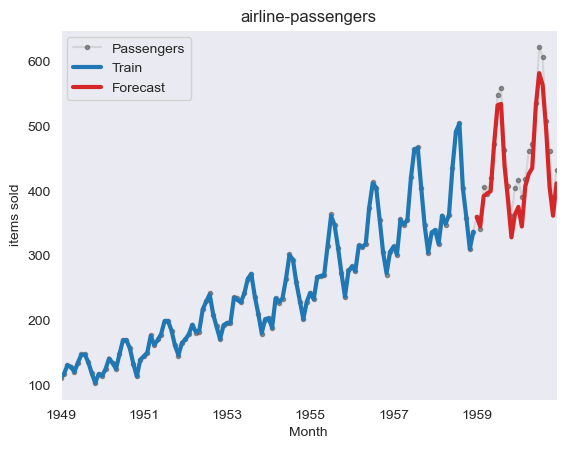

In [42]:
y_pred = pd.Series(reg.predict(temp_train_x), index=temp_train_x.index)
y_fore = pd.Series(reg.predict(temp_test_x), index=temp_test_x.index)

forcast_plot(air_line[['Passengers']], y_pred * trend_train['Passengers'], y_fore * trend_test['Passengers'])

## Plot ACF and PACF

In addition to incorporating time-related features and detrending, we also explored the use of lagged variables to improve the accuracy of our XGBoost model. To identify the most relevant lags, we used autocorrelation and partial autocorrelation plots to determine the strongest correlations between past and current values of the AirPassengers dataset.

We then included these lagged variables as additional features in our XGBoost model, along with the time-related features and detrended data. By incorporating the effects of past values on the current value of the time series, we hoped to capture more of the underlying patterns and fluctuations in the data and improve the accuracy of our model's predictions.

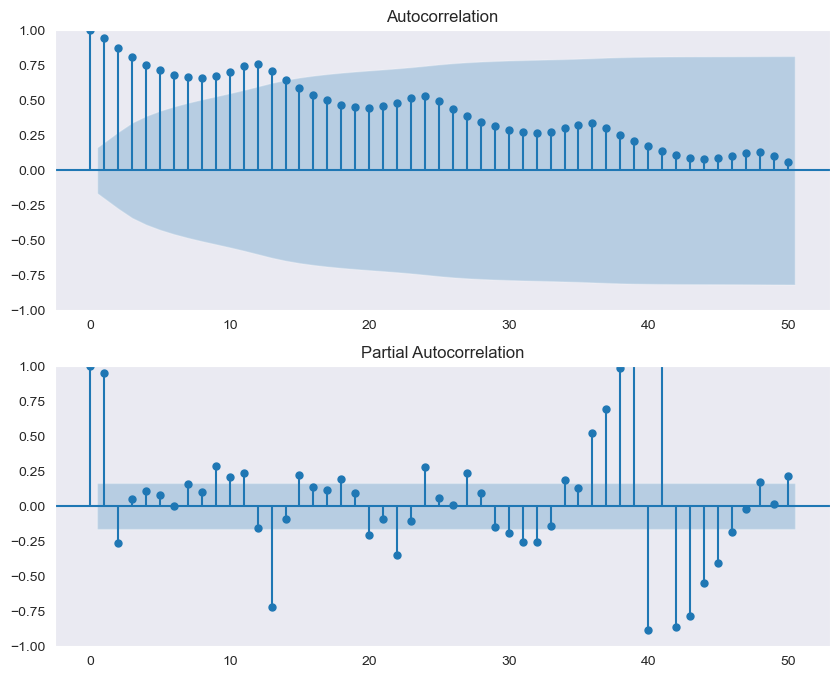

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
plot_acf(air_line['Passengers'], ax=ax[0], lags=50)
plot_pacf(air_line['Passengers'], ax=ax[1], lags=50)
plt.show()

In [46]:
temp_train_x, temp_train_y = get_time(detrend_train), detrend_train['Passengers'] # create_features(detrend_train, 'Passengers')
temp_test_x, temp_test_y = get_time(detrend_test), detrend_test['Passengers'] # create_features(detrend_test, 'Passengers')

lags = [1, 2]
temp_train_x[[f'lag{i}' for i in lags]] = add_lags(detrend_train, lags)
temp_test_x[[f'lag{i}' for i in lags]] = add_lags(detrend_test, lags)


reg = xgb(n_estimators=50, early_stopping_rounds=50)

reg.fit(temp_train_x, temp_train_y,
        eval_set=[(temp_train_x, temp_train_y),
        (temp_test_x, temp_test_y)])

[0]	validation_0-rmse:0.38056	validation_1-rmse:0.39835
[1]	validation_0-rmse:0.27788	validation_1-rmse:0.29533
[2]	validation_0-rmse:0.20525	validation_1-rmse:0.22476
[3]	validation_0-rmse:0.15397	validation_1-rmse:0.17560
[4]	validation_0-rmse:0.11666	validation_1-rmse:0.14410
[5]	validation_0-rmse:0.09089	validation_1-rmse:0.12834
[6]	validation_0-rmse:0.07181	validation_1-rmse:0.11920
[7]	validation_0-rmse:0.05787	validation_1-rmse:0.11836
[8]	validation_0-rmse:0.04702	validation_1-rmse:0.11995
[9]	validation_0-rmse:0.03853	validation_1-rmse:0.12156
[10]	validation_0-rmse:0.03372	validation_1-rmse:0.12461
[11]	validation_0-rmse:0.02885	validation_1-rmse:0.12669
[12]	validation_0-rmse:0.02578	validation_1-rmse:0.12680
[13]	validation_0-rmse:0.02305	validation_1-rmse:0.12569
[14]	validation_0-rmse:0.02120	validation_1-rmse:0.12787
[15]	validation_0-rmse:0.01997	validation_1-rmse:0.12792
[16]	validation_0-rmse:0.01912	validation_1-rmse:0.12799
[17]	validation_0-rmse:0.01816	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

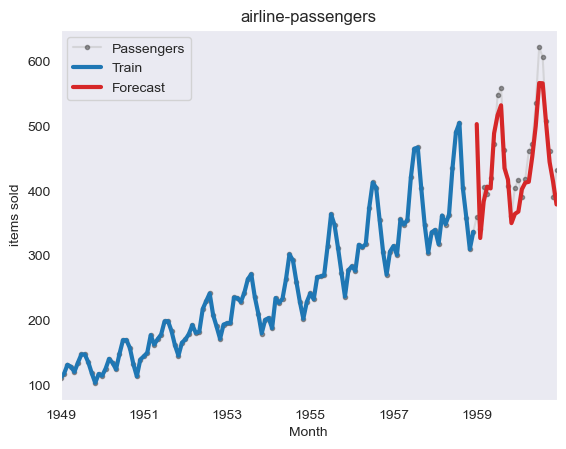

In [64]:
y_pred = pd.Series(reg.predict(temp_train_x), index=temp_train_x.index)
y_fore = pd.Series(reg.predict(temp_test_x), index=temp_test_x.index)

forcast_plot(air_line[['Passengers']], y_pred * trend_train['Passengers'], y_fore * trend_test['Passengers'])

In [65]:
evaluate(test['Passengers'].values, y_fore * trend_test['Passengers'].values)

MAE: 30.56740179663811
RMSE: 41.303537558094064
MAPE: 6.971155096887213


In [48]:
temp_train_x, temp_train_y = create_features(detrend_train, 'Passengers')
temp_test_x, temp_test_y = create_features(detrend_test, 'Passengers')

lags = [1, 2]
temp_train_x[[f'lag{i}' for i in lags]] = add_lags(detrend_train, lags)
temp_test_x[[f'lag{i}' for i in lags]] = add_lags(detrend_test, lags)


reg = xgb(n_estimators=50, early_stopping_rounds=50)

reg.fit(temp_train_x, temp_train_y,
        eval_set=[(temp_train_x, temp_train_y),
        (temp_test_x, temp_test_y)])

[0]	validation_0-rmse:0.38026	validation_1-rmse:0.39991
[1]	validation_0-rmse:0.27534	validation_1-rmse:0.29471
[2]	validation_0-rmse:0.20232	validation_1-rmse:0.22685
[3]	validation_0-rmse:0.14912	validation_1-rmse:0.17685
[4]	validation_0-rmse:0.11089	validation_1-rmse:0.14649
[5]	validation_0-rmse:0.08351	validation_1-rmse:0.12904
[6]	validation_0-rmse:0.06356	validation_1-rmse:0.11824
[7]	validation_0-rmse:0.04906	validation_1-rmse:0.11235
[8]	validation_0-rmse:0.03841	validation_1-rmse:0.10703
[9]	validation_0-rmse:0.03114	validation_1-rmse:0.10393
[10]	validation_0-rmse:0.02530	validation_1-rmse:0.10336
[11]	validation_0-rmse:0.02123	validation_1-rmse:0.10246
[12]	validation_0-rmse:0.01747	validation_1-rmse:0.10007
[13]	validation_0-rmse:0.01519	validation_1-rmse:0.09894
[14]	validation_0-rmse:0.01271	validation_1-rmse:0.09825
[15]	validation_0-rmse:0.01119	validation_1-rmse:0.09793
[16]	validation_0-rmse:0.01042	validation_1-rmse:0.09721
[17]	validation_0-rmse:0.00916	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

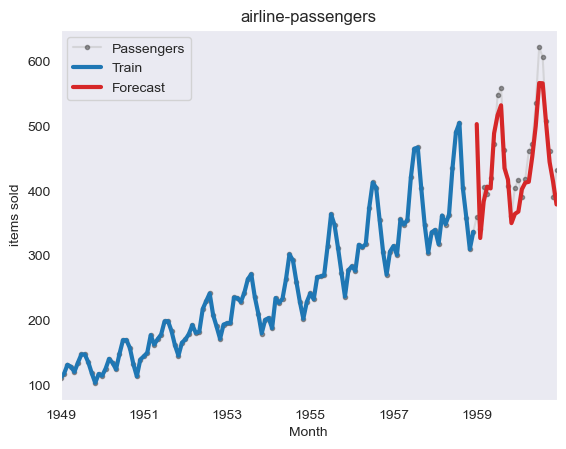

In [49]:
y_pred = pd.Series(reg.predict(temp_train_x), index=temp_train_x.index)
y_fore = pd.Series(reg.predict(temp_test_x), index=temp_test_x.index)

forcast_plot(air_line[['Passengers']], y_pred * trend_train['Passengers'], y_fore * trend_test['Passengers'])

Month
1959-01-01    503.002893
1959-02-01    327.409240
1959-03-01    383.750714
1959-04-01    406.600505
1959-05-01    403.810309
1959-06-01    488.781811
1959-07-01    516.636630
1959-08-01    531.999893
1959-09-01    435.116523
1959-10-01    417.417343
1959-11-01    350.325457
1959-12-01    364.567527
1960-01-01    368.114501
1960-02-01    402.483875
1960-03-01    412.722020
1960-04-01    414.010413
1960-05-01    452.626896
1960-06-01    499.978171
1960-07-01    566.307888
1960-08-01    565.940772
1960-09-01    504.146461
1960-10-01    444.589871
1960-11-01    414.473678
1960-12-01    379.089175
dtype: float64

In [63]:
evaluate(test['Passengers'].values, y_fore * trend_test['Passengers'].values)

MAE: 30.56740179663811
RMSE: 41.303537558094064
MAPE: 6.971155096887213


## Conclusion

Our analysis of the AirPassengers time series dataset suggests that XGBoost performs well when using detrended data and time-related features, which capture the underlying patterns and fluctuations in the data. While including lagged variables can be useful in some cases, our results showed that it did not improve the accuracy of the XGBoost model in this particular dataset, and may even decrease its accuracy. Overall, our findings suggest that XGBoost with detrended data and time-related features can be an effective approach for analyzing time series data.

In [144]:
import lightgbm as lgb

In [146]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(temp_train_x, temp_train_y)
yhat = lightGBM.predict(temp_test_x)
evaluate(temp_test_y, yhat)

MAE: 0.062152770827151226
RMSE: 0.08977741475213108
MAPE: 6.22287407562387


In [150]:
from sklearn.neighbors import KNeighborsRegressor

In [167]:
reg = KNeighborsRegressor(n_neighbors=3)
reg.fit(temp_train_x[2:], temp_train_y[2:])
yhat = reg.predict(temp_test_x[2:])
evaluate(temp_test_y[2:], yhat)

MAE: 0.04948379100934126
RMSE: 0.05663000471620148
MAPE: 4.723355647510815


In [196]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(temp_train_x[2:], temp_train_y[2:])
yhat = reg.predict(temp_test_x[2:])
evaluate(temp_test_y[2:], yhat)

MAE: 0.10000627421813059
RMSE: 0.12626961472409418
MAPE: 9.259916441592942


In [187]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=(temp_train_x.shape[1],1), dropout=dropout),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

In [188]:
train_data = tf.data.Dataset.from_tensor_slices((temp_train_x[2:], temp_train_y[2:]))
train_data = train_data.cache().shuffle(100).batch(32).repeat()

val_data = tf.data.Dataset.from_tensor_slices((temp_test_x[2:], temp_test_y[2:]))
val_data = val_data.batch(32).repeat()

In [189]:
EVALUATION_INTERVAL = 200
EPOCHS = 5

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50) 

Epoch 1/5
200/200 [==============================] - 4s 10ms/step - loss: 0.1519 - val_loss: 0.1100
Epoch 2/5
200/200 [==============================] - 1s 7ms/step - loss: 0.1106 - val_loss: 0.0710
Epoch 3/5
200/200 [==============================] - 1s 7ms/step - loss: 0.0933 - val_loss: 0.0566
Epoch 4/5
200/200 [==============================] - 1s 7ms/step - loss: 0.0809 - val_loss: 0.0845
Epoch 5/5
200/200 [==============================] - 1s 7ms/step - loss: 0.0758 - val_loss: 0.1515


In [191]:
yhat = simple_lstm_model.predict(temp_test_x[2:])

1/1 [==============================] - 0s 317ms/step


In [195]:
evaluate(temp_test_y[2:], yhat.reshape(len(yhat)))

MAE: 0.15148812736105055
RMSE: 0.17293068846087561
MAPE: 13.855302603006772
